# Notebook 04: Experiments and Learning to Rank
This notebook covers the experiments implemented with PyTerrier to recreate the results seen in the paper. 

**The bottom of the notebook contains a way for you to test the LTR models**

In [15]:
# pip install python-terrier lightgbm==3.1.1 seaborn

In [1]:
import pyterrier as pt
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import numpy as np

import seaborn as sns
sns.set_theme(style="darkgrid")

if not pt.started():
    pt.init()

PyTerrier 0.7.1 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)


No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [2]:
index_dir = './bio_index_positions_final'
index_ref = index_dir + '/data.properties'
index_pos = pt.IndexFactory.of(index_ref)
print(index_pos.getCollectionStatistics().toString())

Number of documents: 10008
Number of terms: 19591
Number of postings: 71051
Number of fields: 0
Number of tokens: 73441
Field names: []
Positions:   true



In [3]:
#Left out 3 queries due to issues with annotation files
queries = pd.DataFrame([["0", "healthcare professional"], 
                        ["1", "baseball analyst"],
                        ["2", "talk show host"],
                        ["3", "mechanical engineer"],
                        ["4", "neurosurgeon"],
                        ["5", "movie director"],
                        ["6", "accountant"],
                        ["7", "social media influencer"],
                        ["8", "lawyer"],
                        ["9", "coffee barista"],
                        ["10", "industrial engineer"],
                        ["11", "statistician"],
                        ["12", "data scientist"],
                        ["13", "cryptocurrency investor"],
                        ["14", "investment banker"],
                        ["15", "olympian"],
                        ["16", "software engineer"],
                        #["17", "NLP expert"],
                        #["18", "NFT investor"],
                        # ["19", "marine biologist"],
                        ["20", "doctor"], 
                        ["21", "stockbroker"],
                        ["22", "veterinarian"],
                        ["23", "dentist"],
                        ["24", "receptionist"],
                        ["25", "pharmacist"],
                        ["26", "teacher"],
                        ["27", "architect"],
                        ["28", "police officer"],
                        ["29", "technology CEO"]],
                       columns=["qid", "query"])

In [4]:
author_df = pd.read_csv('./all_author_df.csv')
author_df = author_df.drop('Unnamed: 0', axis=1).reset_index().rename(columns={'index': 'docno'})
author_df['docno'] = author_df['docno'].astype(str)
author_merge = author_df[['author_id', 'handle', 'name']]

In [6]:
def create_load_qrels(query_df):
    if './qrels.csv':
        print('loading qrels.csv')
        qrels = pd.read_csv('./qrels.csv').drop('Unnamed: 0', axis=1)
    else:
        print('Creating qrels')
        qids = list(queries['qid'])
        query_list = list(queries['query'])
        filenames = sorted(os.listdir(annotation_path))
        qids = list(queries['qid'])
        query_list = list(queries['query'])
        qrels = pd.DataFrame(columns = ["qid", "docno", "label"])
        for qid, query, file_n in zip(qids, query_list, filenames):
            file_path = annotation_path + '/' + file_n
            df = pd.read_csv(file_path).dropna()
            df = df.rename(columns={df.columns[0]: 'docno'})
            df['docno'] = df['docno'].astype(str)
            df['label'] = df['label'].astype(int)
            score_col = [x for x in df.columns if 'score_bm25' in x][0]
            out = df[['docno', 'label', score_col]].copy()
            out.loc[:, 'qid'] = qid
            out.loc[:, 'query'] = query

            out = out[['qid', 'docno', 'label']]
            out.columns = ["qid", "docno", "label"]
            qrels = qrels.append(out)

    qrels['label'] = qrels['label'].astype(int)
    qrels['qid'] = qrels['qid'].astype(str)
    qrels['docno'] = qrels['docno'].astype(str)

    return qrels

In [7]:
qrels = create_load_qrels(queries)

loading qrels.csv


/Users/michael/opt/anaconda3/envs/robogames/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'annotated_rank')

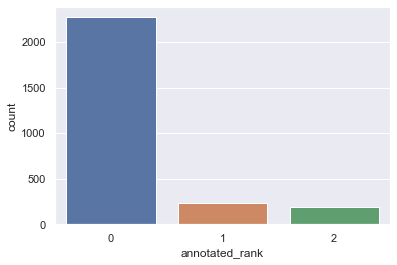

In [8]:
sns.countplot(qrels['label']).set_xlabel('annotated_rank')

In [9]:
#BM25
bm25_pos = pt.BatchRetrieve(index_pos, wmodel="BM25") 
#Sequential Dependence
sdm = pt.rewrite.SDM()
sdm_pipe = sdm >> bm25_pos
#PL2
pl2 = pt.BatchRetrieve(index_pos, wmodel="PL2") 
#Random Documents
random_weighting = lambda keyFreq, posting, entryStats, collStats: random.random()
rand_docs = pt.BatchRetrieve(index_pos, wmodel=random_weighting) 

In [10]:
res = pt.Experiment(
  [bm25_pos, sdm_pipe, pl2, rand_docs],
  queries,
  qrels,
  eval_metrics=["ndcg", "ndcg_cut_10", "map", "P.10", "mrt"],
  names=['BM25', 'SDM', 'PL2', 'Random'],
  baseline=3
)

res.sort_values('P.10', ascending=False)[['name', 'P.10', 'ndcg_cut_10', 'ndcg', 'map', 'mrt']]
# res

,name,P.10,ndcg_cut_10,ndcg,map,mrt
1,SDM,0.500000,0.602734,0.713028,0.613227,5.864178
0,BM25,0.500000,0.602661,0.712896,0.613028,22.941531
2,PL2,0.500000,0.603629,0.712161,0.611580,1.843674
3,Random,0.437037,0.557292,0.694937,0.573960,14.514449


In [11]:
RANK_CUTOFF = 10
SEED=0

tr_va_queries, test_queries = train_test_split(queries, test_size=7, random_state=SEED)
train_queries, valid_queries =  train_test_split(tr_va_queries, test_size=5, random_state=SEED)

valid_qrels = qrels[qrels['qid'].isin(list(valid_queries['qid']))]
test_qrels = qrels[qrels['qid'].isin(list(test_queries['qid']))]
train_qrels = qrels[qrels['qid'].isin(list(train_queries['qid']))]

In [14]:
def get_followers(docno):
    docno = str(docno)
    return author_df[author_df['docno'] == docno]['followers_count'].values[0]

def get_following(docno):
    docno = str(docno)
    return author_df[author_df['docno'] == docno]['following_count'].values[0]

def get_features(row):
    docid = row["docno"]
    followers = get_followers(int(docid))
    following = get_following(int(docid))
    return np.array([followers, following])

In [15]:
featureset_01 = (bm25_pos) >> (
    pt.transformer.IdentityTransformer()
    **
    sdm_pipe
    **
    pt.BatchRetrieve(index_pos, wmodel="PL2")
    **
    pt.apply.doc_features(get_features)
    )
    
f_names = ['BM25_score', 'SDM Score', 'PL2_score', 'followers', 'following']

#Train RF (Pointwise LTR)
rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)
rf_pipe = featureset_01 >> pt.ltr.apply_learned_model(rf)
rf_pipe.fit(train_queries, qrels)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.5s finished


In [ ]:
#Train LambdaMART (Listwise LTR)
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)

lmart_x_pipe = featureset_01 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})
lmart_x_pipe.fit(train_queries, qrels, valid_queries, qrels)

In [19]:
# Evaluate the solutions
res = pt.Experiment([bm25_pos, rf_pipe, lmart_x_pipe, rand_docs], 
              valid_queries, 
              valid_qrels, 
              eval_metrics=["map", "ndcg", "ndcg_cut_10", "mrt", "P.10"], 
              names=["BM25", "Random Forest", "Lambdarank", "Random"], perquery=False)
res.sort_values('P.10', ascending=False)[['name', 'P.10', 'ndcg_cut_10', 'ndcg', 'map', 'mrt']]

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


,name,P.10,ndcg_cut_10,ndcg,map,mrt
0,BM25,0.34,0.484483,0.532565,0.474364,3.214411
1,Random Forest,0.34,0.481380,0.533212,0.477402,113.069824
2,Lambdarank,0.32,0.491653,0.543402,0.477492,57.657095
3,Random,0.32,0.443096,0.516684,0.462453,5.884663


In [20]:
#Fit models with each feature to assess importance
pt.Experiment(
    [featureset_01 >> pt.ltr.feature_to_score(i) for i in range(len(f_names))],
    valid_queries,
    valid_qrels, 
    names=f_names,
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "num_rel_ret"])

,name,map,ndcg,ndcg_cut_10,num_rel_ret
0,BM25_score,0.474364,0.532565,0.484483,34.0
1,SDM Score,0.474364,0.532565,0.484483,34.0
2,PL2_score,0.474703,0.533058,0.491372,34.0
3,followers,0.471306,0.525745,0.473507,34.0
4,following,0.475482,0.531858,0.474562,34.0


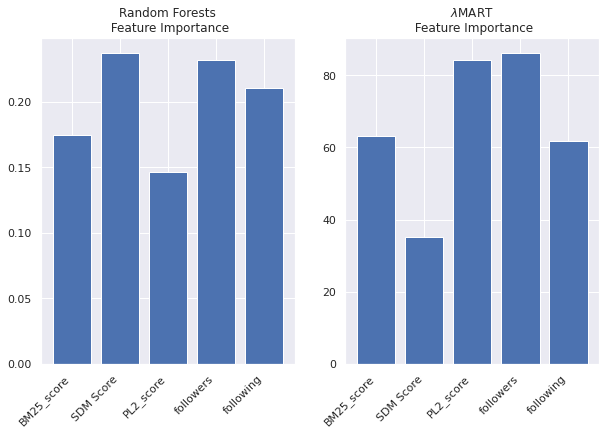

In [21]:
# Inspect the models

%matplotlib inline
import matplotlib.pyplot as plt, numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.bar(np.arange(len(f_names)), rf.feature_importances_)
ax1.set_xticks(np.arange(len(f_names)))
ax1.set_xticklabels(f_names, rotation=45, ha='right')
ax1.set_title("Random Forests\n Feature Importance")

ax2.bar(np.arange(len(f_names)), lmart_l.feature_importances_)
ax2.set_xticks(np.arange(len(f_names)))
ax2.set_xticklabels(f_names, rotation=45, ha='right')
ax2.set_title("$\lambda$MART\n Feature Importance")

fig.show()


In [22]:
# Perform grid search on BM25 to get c, k1, and k3
BM25 = pt.BatchRetrieve(index_pos, wmodel="BM25", controls={"c" : 0.75, "bm25.k_1": 0.75, "bm25.k_3": 0.75})
gridsearch_bm25 = pt.GridSearch(
    BM25,
    {BM25: {"c" : [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1 ],
            "bm25.k_1": [0.3, 0.6, 0.9, 1.2, 1.4, 1.6, 2],
            "bm25.k_3": [0.5, 2, 4, 6, 8, 10, 12, 14, 20]
    }},
    train_queries,
    train_qrels,
    "P.10")

Best P.10 is 0.513333
Best setting is ['BR(BM25) c=0.3', 'BR(BM25) bm25.k_1=0.6', 'BR(BM25) bm25.k_3=0.5']


In [23]:
# Put the new bm25 grid model in the pipeline
bm25_grid_model = pt.BatchRetrieve(index_pos, wmodel="BM25", 
                                   controls={"c" : 0.3, "bm25.k_1": 0.6, "bm25.k_3": 0.5})

featureset_02 = (bm25_grid_model) >> (
    pt.transformer.IdentityTransformer()
    **
    (sdm >> bm25_grid_model)
    **
    pt.BatchRetrieve(index_pos, wmodel="PL2")
    **
    pt.apply.doc_features(get_features)
    )

f_names = ['BM25_score', 'SDM', 'PL2_score', 'followers', 'following']

rf2 = RandomForestRegressor(n_estimators=200, min_samples_split=3, verbose=1, random_state=SEED, n_jobs=2)
rf_pipe2 = featureset_02 >> pt.ltr.apply_learned_model(rf)
rf_pipe.fit(train_queries, qrels)

lmart_x_pipe2 = featureset_02 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})
lmart_x_pipe2.fit(train_queries, qrels, valid_queries, qrels)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    1.1s finished


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1197
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 5
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_r

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [27]:
# Final Experiment on Test Queries
res = pt.Experiment(
    [bm25_pos, rf_pipe, lmart_x_pipe, bm25_grid_model, rf_pipe2, lmart_x_pipe2, rand_docs],
    test_queries,
    test_qrels, 
    names=["BM25",  "BM25 + RF", "BM25 + LMart", "Tuned BM25", 
           "Tuned BM25 + RF", "Tuned BM25 + LMart", "Random"],
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "P.10", "mrt"], baseline=6)

res.sort_values('P.10', ascending=False)[['name', 'P.10', 'ndcg_cut_10', 'ndcg', 'map', 'mrt']]
# res

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


,name,P.10,ndcg_cut_10,ndcg,map,mrt
0,BM25,0.671429,0.827496,0.899900,0.838570,2.803886
3,Tuned BM25,0.671429,0.822764,0.898235,0.835760,3.051109
2,BM25 + LMart,0.642857,0.826172,0.896415,0.827953,161.470933
5,Tuned BM25 + LMart,0.642857,0.818253,0.891492,0.811453,159.988603
1,BM25 + RF,0.614286,0.756275,0.868437,0.795929,276.238477
4,Tuned BM25 + RF,0.614286,0.755076,0.867459,0.794982,215.474190
6,Random,0.571429,0.743383,0.863141,0.778889,19.642353


In [14]:
mod = rf_pipe
# mod = lmart_x_pipe

index_dir = './bio_index_positions_final'
index_ref = index_dir + '/data.properties'
index_pos = pt.IndexFactory.of(index_ref)
bm25_pos = pt.BatchRetrieve(index_pos, wmodel="BM25") 

while True:
    query = input(f"Input a query, or type done (i.e. lawyer): ")
    if query.lower() == 'done':
        break
    res_df = bm25_pos.search(query).merge(author_df, on="docno")[['handle', 'name', 'author_bio']][:5]
    if len(res_df) == 0:
        print('No results. Try again, or type done')
        continue
    else:
        print(f"\nQuery Results\n{'='*100}")
        for row in res_df.iterrows():
            print(f"Handle: @{row[1]['handle'].strip()}")
            print(f"Name: {row[1]['name']}")
            print(f"Bio:\n{row[1]['author_bio']}")
            print('-'*200)

Input a query, or type done (i.e. lawyer): doctor

Query Results
Handle: @lesbianthasmin
Name: marissa is a dark!thirteen whore
Bio:
i would let the thirteenth doctor rail me 
pls read series 14, episode 10 - the doctor pays
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Handle: @manisamartian
Name: Steve
Bio:
Doctor, those that'll tell don't know, and those that know won't tell
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Handle: @GeorgeAnagli
Name: Dr. George 💊
Bio:
| Sixth Year Doctor of Pharmacy | 0dade3 | Host: RxWithDrGeorge | For Business, Email : RxWithDrGeorge@gmail.com |
------------------------------------------------------------------------------------------------------